In [62]:
import os
import matplotlib.pyplot as plt
import jax.numpy as jnp 
import jax 
import equinox as eqx
from typing import Tuple, Callable
import optax
import jax.tree_util as jtu
import random
from jaxtyping import Array, Float, Int, PyTree

In [63]:
IMAGE_SIZE = 64
BATCH_SIZE = 16
BATCH_COUNT = 8
LATENT_DIMS = 64

Lets load some images.

In [2]:
def load_data(path : str, count : int):
    # load all images from this path
    images = []
    i = 0
    for file in os.listdir(path):
        i += 1
        if i > count:
            break
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images


def preprocess(images : list, size : int, batch_size : int, batch_count : int):
    images = [jax.image.resize(image, (size, size, 3), method="linear") for image in images]
    images = jnp.array(images)
    images = images / 255.0

    batches = images.reshape((batch_count, batch_size, size, size, 3))

    return batches

images_raw = load_data("data", count=BATCH_SIZE * BATCH_COUNT)
random.shuffle(images_raw)
batches = preprocess(images_raw, size=IMAGE_SIZE, batch_size=BATCH_SIZE, batch_count=BATCH_COUNT)

2024-06-06 10:55:31.554543: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


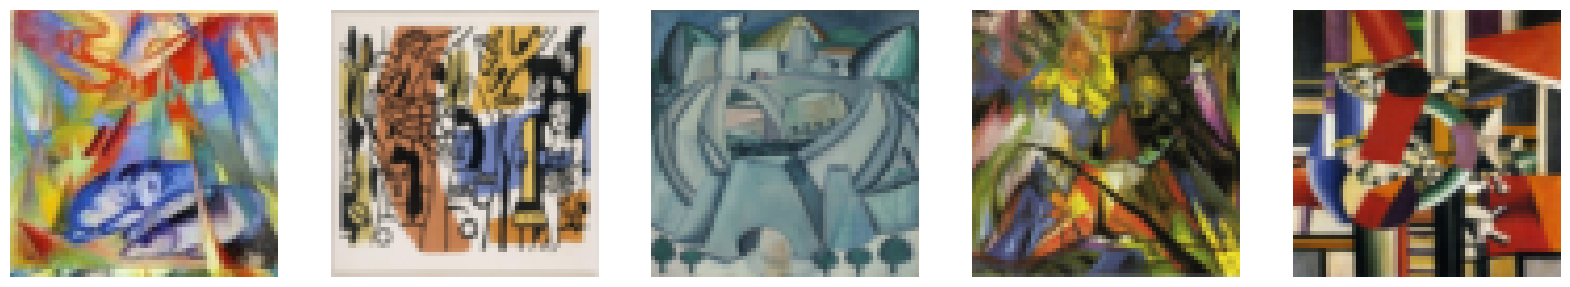

In [64]:
# generate 5 plots in a row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(batches[0][i])
    axs[i].axis("off")

In [122]:
class Generator(eqx.Module):
    layers : list
    
    def __init__(self, 
            key, 
            latent_dim : int, 
            output_dim : int, 
            hidden_dim : int,
            n_channels : int):
    

        if jnp.sqrt(latent_dim) % 1 != 0:
            raise ValueError("latent_dim must be a perfect square")
        
        latent_sqrt = jnp.sqrt(latent_dim).astype(jnp.int32)

        # evaluate number of upscaling layers we need to get to the output_dim
        dim = latent_sqrt
        upscaling_layers = 0
        while dim < output_dim:
            dim *= 2
            upscaling_layers += 1

        print(f"upscaling layers: {upscaling_layers}")
        print(f"hidden size: {hidden_dim}")

        keys = jax.random.split(key, upscaling_layers + 1)

        # first layer maps latent vector to a grid of size hidden_size x latent_sqrt x latent_sqrt
        self.layers = [
            eqx.nn.Linear(
                key=keys[0],
                in_features=latent_dim,
                out_features=latent_dim * hidden_dim),
            jax.nn.leaky_relu,
            lambda x: jnp.reshape(x, (hidden_dim, latent_sqrt, latent_sqrt))]

        for i in range(upscaling_layers):
            self.layers.append(
                eqx.nn.ConvTranspose(
                    key=keys[i + 1],
                    num_spatial_dims=2,
                    in_channels=hidden_dim,
                    out_channels=hidden_dim,
                    kernel_size=4,
                    padding=1,
                    stride=2))
            self.layers.append(jax.nn.leaky_relu)

        # we add another conv without stride to get to the desired output_dim
        self.layers.append(
            eqx.nn.ConvTranspose(
                key=keys[-1],
                num_spatial_dims=2,
                in_channels=hidden_dim,
                out_channels=n_channels,
                kernel_size=3,
                padding=1,
                stride=1))
        
        self.layers.append(jax.nn.tanh)

    def __call__(self, z : Float[Array, "LATENT_DIM"]):
        for layer in self.layers:
            z = layer(z)
        return z

In [123]:
class Critic(eqx.Module):
    layers : list

    def __init__(self, 
        key,
        input_dim : int, 
        n_channels : int):

        dim = input_dim
        downscaling_layers = 0
        while dim > 4:
            dim = dim // 2
            downscaling_layers += 1

        print(f"downscaling layers: {downscaling_layers}")

        keys = jax.random.split(key, downscaling_layers + 1)

        self.layers = []

        for i in range(downscaling_layers):
            self.layers.append(
                eqx.nn.Conv(
                    key=keys[i],
                    num_spatial_dims=2,
                    in_channels=n_channels,
                    out_channels=n_channels,
                    kernel_size=3,
                    padding=1,
                    stride=2))
            self.layers.append(jax.nn.leaky_relu)

        self.layers.append(
            lambda x: jnp.reshape(x, (4 * 4 * n_channels,)))
        self.layers.append(
            eqx.nn.Linear(
                key=keys[-1],
                in_features=n_channels * 4 * 4,
                out_features=1))
        
    def __call__(self, x : Float[Array, "3 IMAGE_SIZE IMAGE_SIZE"]):
        for layer in self.layers:
            x = layer(x)
        return x

In [124]:
def count_parameters(model: eqx.Module):
    return  sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

In [125]:
key = jax.random.PRNGKey(0)
key, gen_key, crit_key = jax.random.split(key, 3)

generator = Generator(
    key=gen_key,
    latent_dim=LATENT_DIMS,
    output_dim=IMAGE_SIZE,
    hidden_dim=8,
    n_channels=3)

print(f"Generator parameters: {count_parameters(generator)}")

critic = Critic(
    key=crit_key,
    input_dim=IMAGE_SIZE,
    n_channels=3)

print(f"Critic parameters: {count_parameters(critic)}")


upscaling layers: 3
hidden size: 8
Generator parameters: 36595
downscaling layers: 4
Critic parameters: 385


In [126]:
ket, noise_key = jax.random.split(key, 2)
input_data = jax.random.normal(noise_key, (LATENT_DIMS, ))
output_data = generator(input_data)

critic_value = critic(output_data)

assert output_data.shape == (3, IMAGE_SIZE, IMAGE_SIZE)
assert critic_value.shape == (1,)


In [129]:
def generate_images(key, generator : Generator, count : int, latent_dims : int):
    z = jax.random.normal(key, (count, latent_dims))
    return jax.vmap(generator)(z)

def generator_loss_fn(
    key,
    generator : Generator, 
    critic : Critic):

    images = generate_images(key, generator, BATCH_SIZE, LATENT_DIMS)
    critic_vals = jax.vmap(critic)(images)

    loss = -jnp.mean(critic_vals)

    return loss

def critic_loss_fn(
    key,
    generator : Generator, 
    critic : Critic, 
    real_images : Float[Array, "BATCH_SIZE 3 IMAGE_SIZE IMAGE_SIZE"]):

    images = generate_images(key, generator, BATCH_SIZE, LATENT_DIMS)
    critic_vals_generated = jax.vmap(critic)(images)
    critic_vals_real = jax.vmap(critic)(real_images)

    generated_loss = optax.sigmoid_binary_cross_entropy(critic_vals_generated, jnp.zeros_like(critic_vals_generated))
    real_loss = optax.sigmoid_binary_cross_entropy(critic_vals_real, jnp.ones_like(critic_vals_real))

    loss = jnp.mean(generated_loss) + jnp.mean(real_loss)

    return loss

In [130]:
@eqx.filter_jit
def update_step(
    key,
    generator : Generator,
    critic : Critic,
    generator_optimizer : optax.GradientTransformation,
    critic_optimizer : optax.GradientTransformation,    
    generator_optimizer_state : optax.OptState,
    critic_optimizer_state : optax.OptState,
    batch : Float[Array, "BATCH_SIZE 3 IMAGE_SIZE IMAGE_SIZE"]):

    critic_key, generator_key = jax.random.split(key, 2)

    critic_loss, critic_grads = eqx.filter_value_and_grad(critic_loss_fn)( 
        critic_key,
        generator, 
        critic, 
        batch)
    
    critic_update, new_critic_optimizer_state =\
        critic_optimizer.update(critic_grads, critic_optimizer_state)
    new_generator = eqx.apply_updates(generator, critic_update)

    generator_loss, generator_grads = eqx.filter_value_and_grad(generator_loss_fn)(
        generator_key,
        generator,
        critic)
    
    generator_update, new_generator_optimizer_state =\
        generator_optimizer.update(generator_grads, generator_optimizer_state)
    
    new_generator = eqx.apply_updates(generator, generator_update)

    return new_generator, new_critic_optimizer_state, new_generator_optimizer_state, critic_loss, generator_loss
    

In [131]:
optimizer_critic = optax.adam(1e-4)
optimizer_generator = optax.adam(1e-4)

optimizer_critic_state = optimizer_critic.init(eqx.filter(critic, eqx.is_array))
optimizer_generator_state = optimizer_generator.init(eqx.filter(generator, eqx.is_array))

num_epochs = 100

critic_losses = []
generator_losses = []
for epoch in range(num_epochs):

  for i in range(len(batches)):
    generator, critic, optimizer_generator_state, optimizer_critic_state, critic_loss, generator_loss = update_step(
      key, 
      generator, 
      critic,
      optimizer_generator,
      optimizer_critic,
      optimizer_generator_state,
      optimizer_critic_state,
      batches[i])
    
    critic_losses.append(critic_loss)
    generator_losses.append(generator_loss)

  print(f"Epoch {epoch} - Critic loss: {jnp.mean(critic_losses)} - Generator loss: {jnp.mean(generator_losses)}")
  

ValueError: conv_general_dilated lhs feature dimension size divided by feature_group_count must equal the rhs input feature dimension size, but 64 // 1 != 3.

In [14]:
from functools import partial

def reconstruction_loss(network_params : optax.Params,  network : nn.Module, images : jnp.ndarray):
  # print(images.shape)
  prediction = network.apply(network_params, images)
  # print(prediction.shape)
  # print(prediction.shape, images.shape)
  loss = jnp.mean(jnp.sum(jnp.square(prediction - images), axis=(-1)))
  return loss

@partial(jax.jit, static_argnums=(1,2))
def train_step(
  batch : jnp.ndarray,
  network : nn.Module,
  optimizer : optax.GradientTransformation,
  optimizer_state : optax.OptState,
  network_params : optax.Params):

  grad_fn = jax.value_and_grad(reconstruction_loss, argnums=0)
  loss, grads = grad_fn(network_params, network, batch)

  updates, new_opt_state = optimizer.update(grads, optimizer_state)

  new_network_params = optax.apply_updates(network_params, updates)

  return loss, new_network_params, new_opt_state

NameError: name 'nn' is not defined

In [ ]:
init_rng = jax.random.key(0)

learning_rate = 0.003

autoencoder = Autoencoder(n_channels=3)

network_params = autoencoder.init(init_rng, batches[0][0])
print(batches[0].shape)
# autoencoder_params = autoencoder_state
optimizer = optax.adam(learning_rate)
optimizer_state = optimizer.init(network_params)

num_epochs = 60

for epoch in range(num_epochs):

    def body_func(i, state):
        loss_sum, network_params, optimizer_state = state
        loss, network_params, optimizer_state = train_step(batches[i], autoencoder, optimizer, optimizer_state, network_params)
        return loss_sum + loss, network_params, optimizer_state
    
    state = (0., network_params, optimizer_state)
    state = jax.lax.fori_loop(0, len(batches), body_func, state)

    loss, network_params, optimizer_state = state

    print(f"Epoch {epoch}, Loss: {loss}")